##Data Cleaning

###To normalize or clean the description type features in the dataset

##Load the dataset using pd.read_csv

In [ ]:
df.head()

,Unnamed: 0,Unnamed: 0.1,PartNumber,FeatureNumber,processedFD,InspectionType,Equipment,Method,OpnNo,LSL_2,USL_2,ActualResult,MEAction,alt_remark
0,0,0,KH27495,FI-1,check visual defect,Visual,100FINSP01,2,4200,0.00,0.00,0.000,QR,others
1,1,1,KH56282,62-2,distance inner vertical face outer vertical face,CMM,000CMM0002,0,1610,8.97,9.00,0.000,CR,accepted stage control
2,2,2,KH56282,34,length outer step face datum inner middle face,CMM,000CMM0002,0,1410,7.27,7.30,7.291,CR,limit conclusion
3,3,3,KH47279,117.1,thickness inner face edge outer face inner gro...,"Dig. Vernier (0-150, 0.01LC)",082MSPTU01,0,3010,0.25,0.75,0.980,QR,reject conclusion
4,4,4,KH47279,VI,check visual defect per wiqa01,Visual,082MSPTU01,0,3010,0.00,0.00,0.000,QR,reject conclusion


In [ ]:
# removing stop words (is, a...)
def rem_stop(sent):
    stop_words = set(stopwords.words('english'))
 
    word_tokens = word_tokenize(sent)
 
    cleansent = [w for w in word_tokens if not w.lower() in stop_words]
     
    cleansent = []
 
    for w in word_tokens:
         if w not in stop_words:
            cleansent.append(w)
    cleansent = ' '.join(cleansent)
    return cleansent

In [ ]:
# Don't -> Do not, I'd -> I would
def expand_contractions(text):
    
    expanded_words = []   
    for word in text.split():
  # using contractions.fix to expand the shortened words
      expanded_words.append(contractions.fix(word))  
   
    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [ ]:
#stemming
def stem(text):
    ps = nltk.porter.PorterStemmer()
    text = ' '.join([ps.stem(word) for word in text.split()])
    return text

In [ ]:
#Lemmatization
def lemmatize_text(text):
    wnl = WordNetLemmatizer()
    list1 = nltk.word_tokenize(text)
    lemmatized_string = ' '.join([wnl.lemmatize(words) for words in list1])
    return lemmatized_string

In [ ]:
#remove special characters
def remove_special_characters(text, remove_digits=False):
    pattern = r'[^a-zA-Z0-9\s]|\[|\]' if not remove_digits else r'[^a-zA-Z\s]|\[|\]'
    text = re.sub(pattern, '', text)
    return text

In [ ]:
def preprocess_text(sen, contraction_expansion=True,
                     text_lower_case=True, 
                     text_lemmatization=True, remove_digits=False,
                     special_char_removal = True,
                     stopword_removal=True):
   
    if contraction_expansion:
            sen = expand_contractions(sen)

    if text_lemmatization:
            sen = lemmatize_text(sen)    
            
    if special_char_removal:  
            special_char_pattern = re.compile(r'([{.(-)!}])')
            sen = special_char_pattern.sub(" \\1 ", sen)
            sen = remove_special_characters(sen, remove_digits=remove_digits)      
            
    if text_lower_case:
            sen = sen.lower()    

    if stopword_removal:
            sen = rem_stop(sen)    
            
    return sen   

In [ ]:
#Passing sentences to the preprocessing function
z = []
sentences = list(df['feature_label_name'])
for sen in sentences:
    z.append(preprocess_text(sen))

In [ ]:
# For converting categorical string label values to categorical integer values
def col_conv(df,col):
  l=list(df[col].unique())
  d={k:i for i,k in enumerate(l)}
  df=df.replace({col: d})
  return d,df

You can save the dataset and load it or just go with existing format

In [ ]:
label_dict,dataset=col_conv(dataset,'label_name')
print(label_dict)
print(list(dataset['label_name'].unique()))

{'QR': 0, 'CR': 1, 'CP': 2, 'RW': 3, 'RI': 4}
[0, 1, 2, 3, 4]


#Tf Multi-Output Multi-Class Model

##Import

Importing the necessary modules

###Basic

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from google.colab import drive
from google.colab import files

import re
import argparse
import random
import pickle
import cv2
import os

###TF

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Lambda
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from sklearn.utils import compute_class_weight
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix,plot_confusion_matrix,f1_score

###TF Version

In [ ]:
tf.__version__

'2.8.0'

##Mount Drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


##Label Values

Saving the label dicts here for future experimentation 

##Dataload

In [ ]:
dataset=pd.read_csv('Path of the file')
dataset.head()

,PartNumber,FeatureNumber,processedFD,InspectionType,Equipment,Method,OpnNo,LSL_2,USL_2,ActualResult,MEAction,alt_remark
0,KH27495,FI-1,check visual defect,Visual,100FINSP01,2,4200,0.00,0.00,0.000,0,0
1,KH56282,62-2,distance inner vertical face outer vertical face,CMM,000CMM0002,0,1610,8.97,9.00,0.000,1,1
2,KH56282,34,length outer step face datum inner middle face,CMM,000CMM0002,0,1410,7.27,7.30,7.291,1,2
3,KH47279,117.1,thickness inner face edge outer face inner gro...,"Dig. Vernier (0-150, 0.01LC)",082MSPTU01,0,3010,0.25,0.75,0.980,0,3
4,KH47279,VI,check visual defect per wiqa01,Visual,082MSPTU01,0,3010,0.00,0.00,0.000,0,3


##Dataset Info

In [ ]:
def uniq(dataset):
  df_unique=pd.DataFrame({"Number of unique values":list(dataset.nunique())})
  df_unique.index = dataset.columns.values.tolist()
  print(df_unique)

In [ ]:
uniq(dataset)

                Number of unique values
PartNumber                          135
FeatureNumber                       702
processedFD                         953
InspectionType                       79
Equipment                            50
Method                                7
OpnNo                               153
LSL_2                               771
USL_2                               798
ActualResult                       2542
MEAction                              5
alt_remark                           15


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6691 entries, 0 to 6690
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   PartNumber      6691 non-null   object 
 1   FeatureNumber   6691 non-null   object 
 2   processedFD     6691 non-null   object 
 3   InspectionType  6691 non-null   object 
 4   Equipment       6691 non-null   object 
 5   Method          6691 non-null   int64  
 6   OpnNo           6691 non-null   int64  
 7   LSL_2           6691 non-null   float64
 8   USL_2           6691 non-null   float64
 9   ActualResult    6691 non-null   float64
 10  MEAction        6691 non-null   int64  
 11  alt_remark      6691 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 627.4+ KB


In [ ]:
dataset.describe()

,Method,OpnNo,LSL_2,USL_2,ActualResult,MEAction,alt_remark
count,6691.000000,6691.000000,6691.000000,6691.000000,6691.000000,6691.000000,6691.000000
mean,1.293379,2360.252130,121.424118,121.868517,110.536148,1.469437,5.992228
std,1.498035,895.629144,235.189332,235.211083,230.080116,0.768056,4.440633
min,0.000000,1001.000000,-311.000000,-310.500000,-310.490000,0.000000,0.000000
25%,0.000000,1610.000000,0.000000,0.030000,0.000000,1.000000,1.000000
50%,1.000000,2210.000000,1.250000,1.900000,0.192000,1.000000,7.000000
75%,2.000000,2840.000000,40.785000,40.985000,25.417000,2.000000,10.000000
max,8.000000,6020.000000,883.570000,883.630000,883.649000,4.000000,14.000000


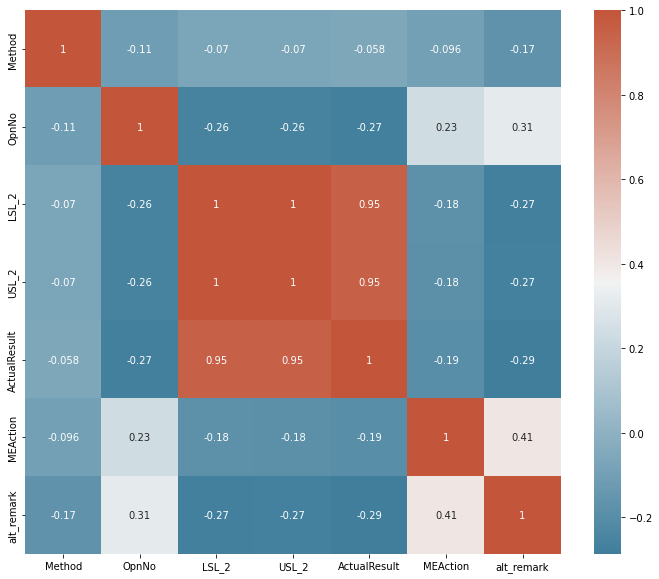

In [ ]:
%matplotlib inline
corr = dataset.corr()
f, ax = plt.subplots(figsize=(12, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, annot=True, cmap=cmap)

For visualizing the sample label counts in particular label or features

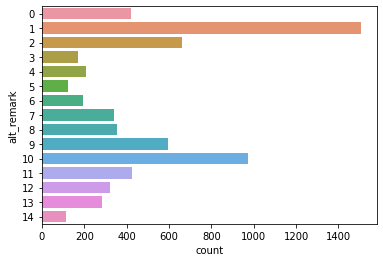

In [ ]:
sns.countplot(data = dataset, y = 'column_name')

In [ ]:
dataset['column_name'].value_counts()

1    4127
2    1464
3     899
0     181
4      20
Name: MEAction, dtype: int64

##Manipulating dataset as train and test

Feature and Label names

In [ ]:
column=['column_name_1','cloumn_name_2',....]

In [ ]:
feat=['feature_name_1','feature_name_2']
label=['label_name_1','label_name_2']

Shuffling the dataset

In [ ]:
dataset = dataset.reindex(np.random.permutation(dataset.index))

Splitting the dataset

In [ ]:
train,test = np.split(dataset.sample(frac=1), [int(0.85*len(dataset))])

In [ ]:
len(train),len(test)

(5687, 1004)

In [ ]:
def df_to_dataset(dataframe,label,shuffle=True, batch_size=32):
  df = dataframe.copy()
  actn,remn=len(df[label[0]].unique()),len(df[label[1]].unique())
  action = df.pop(label[0])
  remark = df.pop(label[1])
  #action,remark=action.values,remark.values
  #action=action.values.reshape(action.shape[0],1)
  #remark=remark.values.reshape(remark.shape[0],1)
  #action=tf.keras.utils.to_categorical(action, num_classes=actn)
  #remark=tf.keras.utils.to_categorical(remark, num_classes=remn)
  df = {key: value[:,tf.newaxis] for key, value in df.items()}
  #inp = tf.data.Dataset.from_tensor_slices(dict(df))
  #out = tf.data.Dataset.from_tensor_slices((action,remark))
  ds = tf.data.Dataset.from_tensor_slices((dict(df),{"action_output": action, "remark_output": remark}))
  #ds = tf.data.Dataset.zip((inp, out))
  #ds = tf.data.Dataset.from_tensor_slices((dict(df),remark))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  ds = ds.prefetch(batch_size)
  #ds = ds.repeat()
  return ds
  #,action,remark

In [ ]:
batch_size = 16
train_ds = df_to_dataset(train,label, batch_size=batch_size)
test_ds = df_to_dataset(test,label, shuffle=False, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
[(train_features, label_batch)] = train_ds.take(1)
print('Every feature:', list(train_features.keys()))
print('A batch of OpnNo:', train_features['OpnNo'])
print('A batch of action:', label_batch )
print('A batch of remark:', label_batch )

Every feature: ['PartNumber', 'FeatureNumber', 'processedFD', 'InspectionType', 'Equipment', 'Method', 'OpnNo', 'LSL_2', 'USL_2', 'ActualResult']
A batch of OpnNo: tf.Tensor(
[[2440]
 [3080]
 [3385]
 [2410]
 [1410]
 [3785]
 [1825]
 [2185]
 [1825]
 [1210]
 [2305]
 [4600]
 [2785]
 [2005]
 [2830]
 [2020]], shape=(16, 1), dtype=int64)
A batch of action: {'action_output': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([3, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 2, 1, 1, 2, 2])>, 'remark_output': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([10, 13,  2,  1,  6,  8,  9, 10,  9,  2, 12,  0, 13,  2,  5,  4])>}
A batch of remark: {'action_output': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([3, 1, 1, 1, 1, 1, 2, 3, 2, 1, 1, 2, 1, 1, 2, 2])>, 'remark_output': <tf.Tensor: shape=(16,), dtype=int64, numpy=array([10, 13,  2,  1,  6,  8,  9, 10,  9,  2, 12,  0, 13,  2,  5,  4])>}


##Preprocessing Layer

In [ ]:
n_num_feat=['Real numerical feature names',...]
buck_feat=['Categorical numerical feature names',...]
s_emb_feat=['string or object feature names',...]
text_vec=['string or object feature name with description type data',..]

In [ ]:
all_inputs = []
encoded_features = []

In [ ]:
def get_normalization_layer(name, dataset):
  # Create a Normalization layer for the feature.
  normalizer = layers.Normalization(axis=None)

  # Prepare a Dataset that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])

  # Learn the statistics of the data.
  normalizer.adapt(feature_ds)

  return normalizer

In [ ]:
# Numerical features.
for header in n_num_feat:
  numeric_col = tf.keras.Input(shape=(1,), name=header)
  normalization_layer = get_normalization_layer(header, train_ds)
  encoded_numeric_col = normalization_layer(numeric_col)
  all_inputs.append(numeric_col)
  
  encoded_features.append(encoded_numeric_col)

In [ ]:
def get_category_encoding_layer(name, dataset, dtype, dim=16,max_tokens=None,bin=None):
  # Create a layer that turns strings into integer indices.
  if dtype == 'string':
    if name in string_vec:
      index = layers.StringLookup(max_tokens=max_tokens)
    else:
      index = layers.TextVectorization(output_sequence_length=20)
  # Otherwise, create a layer that turns integer values into integer indices.
  else:
      normal = layers.Normalization(axis=None)
      index = layers.Discretization(num_bins=bin)
      #index = layers.IntegerLookup(max_tokens=max_tokens)

  # Prepare a `tf.data.Dataset` that only yields the feature.
  feature_ds = dataset.map(lambda x, y: x[name])
  if dtype != 'string':
    normal.adapt(feature_ds)
  # Learn the set of possible values and assign them a fixed integer index.
  index.adapt(feature_ds)

  # Encode the integer indices.
  if dtype == 'string':
    encoder = layers.Embedding(input_dim=index.vocabulary_size(),output_dim=dim)
  else:
    encoder = layers.Embedding(input_dim=bin+1,output_dim=dim)
    '''else:
      encoder = layers.Embedding(input_dim=index.vocabulary_size(),output_dim=dim)'''

  # Apply multi-hot encoding to the indices. The lambda function captures the
  # layer, so you can use them, or include them in the Keras Functional model later.
  if dtype != 'string':
    return lambda feature: encoder(index(normal(feature)))
  else:
    return lambda feature: encoder(index(feature))

add sparse = true for large unique values in a column

In [ ]:
for header in buck_feat:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='int64')
  dim= # Enter the dimension value
  bin= # Enter the bin value
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='int64',
                                               dim=dim,
                                               max_tokens=5,
                                               bin=bin)
  encoded_categorical_col = encoding_layer(categorical_col)
  encoded_categorical_col= Flatten()(encoded_categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

In [ ]:
for header in s_emb_feat:
  categorical_col = tf.keras.Input(shape=(1,), name=header, dtype='string')
  encoding_layer = get_category_encoding_layer(name=header,
                                               dataset=train_ds,
                                               dtype='string',
                                               dim=30,
                                               max_tokens=5)
  encoded_categorical_col = encoding_layer(categorical_col)
  encoded_categorical_col= Flatten()(encoded_categorical_col)
  all_inputs.append(categorical_col)
  encoded_features.append(encoded_categorical_col)

##Model Building

###Hidden Layers

In [ ]:
def multi_dense_block(u1, u2, u3, d1, d2, d3, x, l1r = 0.0001):
  x = Dense(u1, activation = "swish")(x)
  x = Dense(u2, activation = "swish")(x)

  x = Dense(u2, activation = "swish")(x)
  #x = Dropout(d2)(x)
  x = Dense(u3)(x)
  #x = tf.keras.layers.PReLU(alpha_initializer='zeros',alpha_regularizer=None)(x)

  '''x = Dense(u3, activation = "swish")(x)
  x = Dropout(d3)(x)
  x = Dense(u1, activation = "swish")(x)'''

  x = Dense(u1)(x)
  x = Dense(u2)(x)
  x = Dense(abs(u2-u1),activity_regularizer=regularizers.L1(l1=l1r))(x)

  x = Activation("swish")(x)

  return x

In [ ]:
def high_dense_block(units, dropout_rate, x, l1r=0.0001):
       
  x = tf.keras.layers.Dense(units,activity_regularizer=regularizers.L1(l1=l1r))(x)
  x = Activation("swish")(x)
  #x = tf.keras.layers.PReLU(alpha_initializer='zeros',alpha_regularizer=None)(x)

  return x

In [ ]:
def flatten_dense_block(units,x):

  x = Flatten()(x)
  x = Dense(units)(x)

  return x

###Action Layer

In [ ]:
'''def build_act(inputs, numAction, flat=256, finalAct="softmax"):

  x = tf.keras.layers.Dense(38)(inputs)

  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  x = high_dense_block(500,0.25,x,0.0003)
  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)

  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  x = high_dense_block(800,0.4,x,0.0001)
  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)

  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  x = high_dense_block(500,0.25,x,0.0001)
  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  
  x = flatten_dense_block(flat,x)

  x = Dense(numAction,activation=finalAct, name="action_output")(x)

  return x'''

'def build_act(inputs, numAction, flat=256, finalAct="softmax"):\n\n  x = tf.keras.layers.Dense(38)(inputs)\n\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  x = high_dense_block(500,0.25,x,0.0003)\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  x = high_dense_block(800,0.4,x,0.0001)\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  x = high_dense_block(500,0.25,x,0.0001)\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  \n  x = flatten_dense_block(flat,x)\n\n  x = Dense(numAction,activation=finalAct, name="action_output")(x)\n\n  return x'

In [ ]:
def build_act(inputs, numAction, finalAct="softmax"):
  x = tf.keras.layers.Dense(1000, activation = "relu")(inputs)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = Dense(500)(x)
  x = tf.keras.layers.Dropout(0.25)(x)
  x = Dense(100)(x)
  x = Activation("relu")(x)
  x = Dropout(0.3)(x)

  x = Dense(328)(x)
  x = Activation("relu")(x)
  x = Dropout(0.4)(x)

  x= Dense(512)(x)
  x=Dropout(0.5)(x)
  x = Dense(numAction)(x)
  x = Activation(finalAct, name="action_output")(x)

  return x

###Remark Layer

In [ ]:
def build_rmk(inputs, numRemark, finalAct="softmax"):
  x = tf.keras.layers.Dense(2000, activation = "swish")(inputs)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = Dense(512,activation="swish")(x)
  x = tf.keras.layers.Dropout(0.1)(x)
  x = Dense(256)(x)
  x = Activation("swish")(x)
  x = Dropout(0.15)(x)

  x = Dense(64)(x)
  x = Activation("swish")(x)
  x = Dropout(0.15)(x)

  x= Dense(20)(x)
  x= Dense(356)(x)
  x=Flatten()(x)
  x=Dropout(0.3)(x)
  x = Dense(numRemark)(x)
  x = Activation(finalAct, name="remark_output")(x)


  return x

In [ ]:
'''def build_rmk(inputs, numRemark, flat=256, finalAct="softmax"):

  x = tf.keras.layers.Dense(38)(inputs)

  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  x = high_dense_block(500,0.25,x,0.003)
  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)

  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  x = high_dense_block(800,0.4,x,0.001)
  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)

  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  x = high_dense_block(500,0.25,x,0.003)
  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)
  
  x = flatten_dense_block(flat,x)

  x = Dense(numRemark,activation=finalAct, name="remark_output")(x)

  return x'''

'def build_rmk(inputs, numRemark, flat=256, finalAct="softmax"):\n\n  x = tf.keras.layers.Dense(38)(inputs)\n\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  x = high_dense_block(500,0.25,x,0.003)\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  x = high_dense_block(800,0.4,x,0.001)\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  x = high_dense_block(500,0.25,x,0.003)\n  x = multi_dense_block(152,76,190,0.15,0.25,0.20,x)\n  \n  x = flatten_dense_block(flat,x)\n\n  x = Dense(numRemark,activation=finalAct, name="remark_output")(x)\n\n  return x'

###Main Layer

In [ ]:
def build_main(input,feat,n_act,n_rmk,final):
  all_features = tf.keras.layers.concatenate(feat)

  categoryAction =build_act(all_features,n_act, finalAct=final)
  categoryRemark = build_rmk(all_features,n_rmk,finalAct=final)
  
  model = tf.keras.Model(
      inputs=input,
      outputs=[categoryAction,categoryRemark],
      #outputs=categoryRemark,
      name="Project_name")
  return model

###Create Model

In [ ]:
0.003

0.003

In [ ]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    0.001,
    decay_steps=20,
    decay_rate=0.95,
    staircase=True)

In [ ]:
EPOCHS = 60
INIT_LR = lr_schedule
BS = 16

In [ ]:
model=build_main(all_inputs,encoded_features,len(dataset[label[0]].unique()),len(dataset[label[1]].unique()),"softmax")

losses = {
	"action_output": tf.keras.losses.SparseCategoricalCrossentropy(),
	"remark_output": tf.keras.losses.SparseCategoricalCrossentropy(),}

metric=["accuracy"]

lossWeights = {
		"action_output": 1.0, 
		"remark_output": 0.30}


print("[INFO] compiling model...")
opt = Adam(learning_rate=INIT_LR)
metrics={
		"action_output": metric, 
		"remark_output": metric}
model.compile(optimizer=opt, 
              loss=losses, 
              loss_weights=lossWeights,
	metrics=metrics)

[INFO] compiling model...


###Blueprint of the model

In [ ]:
model.summary()

Model: "IAMPL"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Method (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 OpnNo (InputLayer)             [(None, 1)]          0           []                               
                                                                                                  
 normalization_18 (Normalizatio  (None, 1)           3           ['Method[0][0]']                 
 n)                                                                                               
                                                                                                  
 normalization_19 (Normalizatio  (None, 1)           3           ['OpnNo[0][0]']              

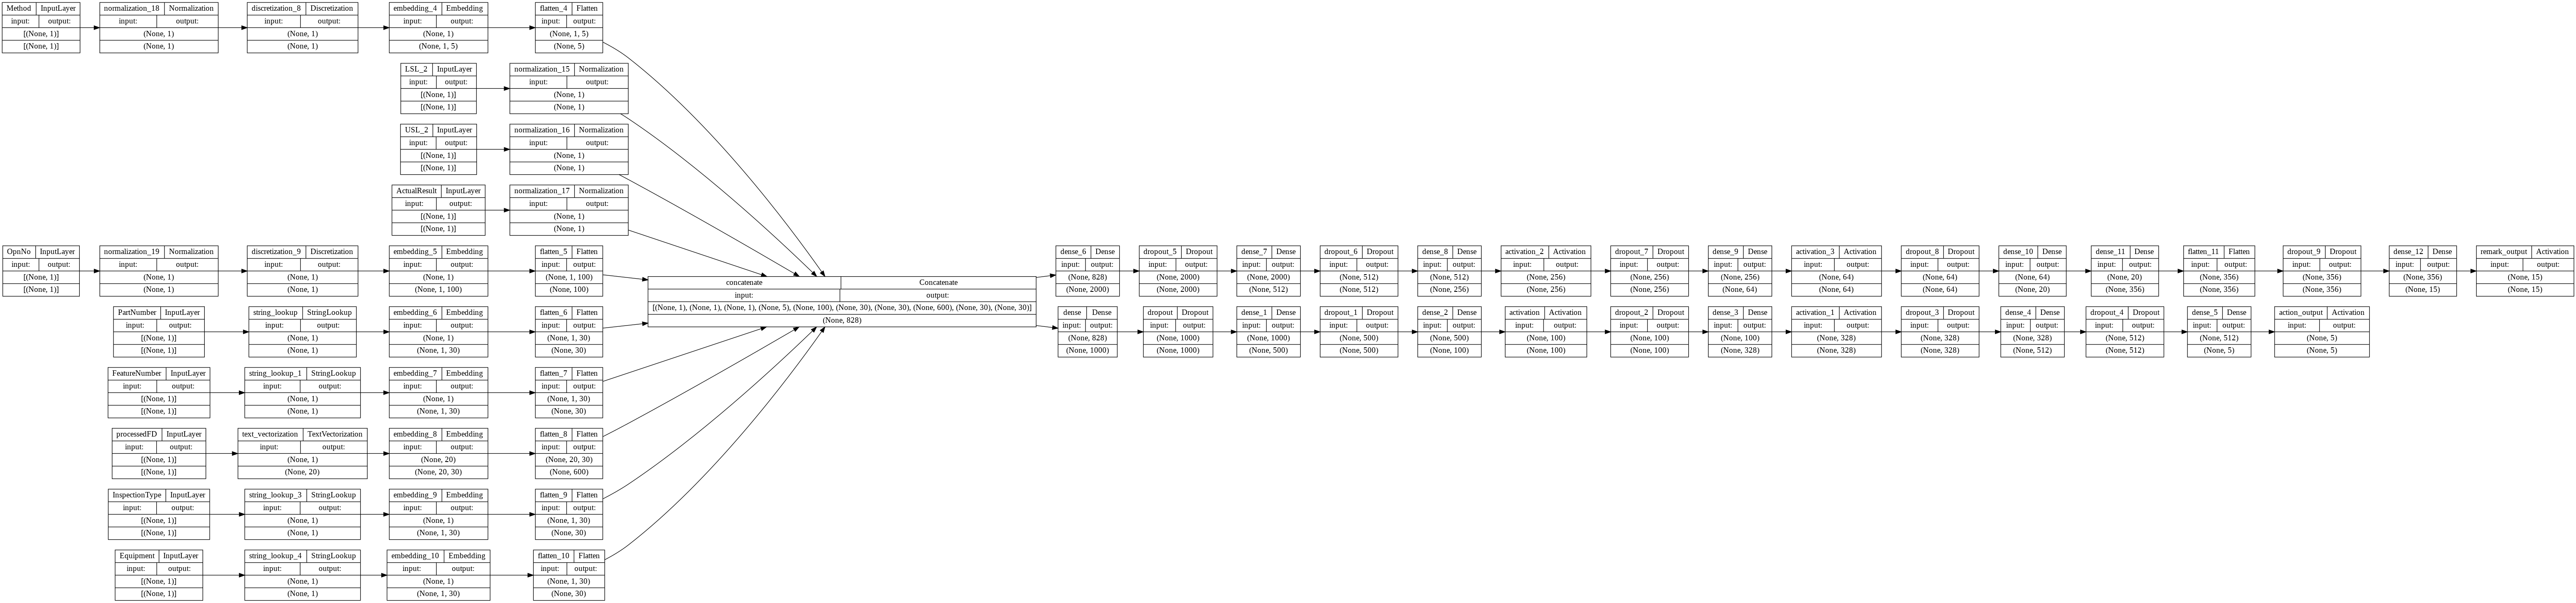

In [ ]:
# Use `rankdir='LR'` to make the graph horizontal.
tf.keras.utils.plot_model(model, show_shapes=True, rankdir="LR")

###Checkpoints and Early_Stopping

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=15,
                                                     restore_best_weights=True)

In [ ]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.002, 1000)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

###Train Model

In [ ]:
Hist = model.fit(train_ds,
                 epochs=EPOCHS,
                 batch_size=BS,
                 verbose=1,
                 validation_data=test_ds,
                 callbacks=[early_stopping_cb],
                 )

Epoch 1/60
356/356 [==============================] - 26s 59ms/step - loss: 1.5334 - action_output_loss: 0.8964 - remark_output_loss: 2.1236 - action_output_accuracy: 0.6661 - remark_output_accuracy: 0.3204 - val_loss: 1.2494 - val_action_output_loss: 0.7178 - val_remark_output_loss: 1.7720 - val_action_output_accuracy: 0.7719 - val_remark_output_accuracy: 0.4333
Epoch 2/60
356/356 [==============================] - 14s 40ms/step - loss: 1.1993 - action_output_loss: 0.6843 - remark_output_loss: 1.7166 - action_output_accuracy: 0.7712 - remark_output_accuracy: 0.4442 - val_loss: 1.1563 - val_action_output_loss: 0.6648 - val_remark_output_loss: 1.6385 - val_action_output_accuracy: 0.7869 - val_remark_output_accuracy: 0.4741
Epoch 3/60
356/356 [==============================] - 14s 40ms/step - loss: 1.0841 - action_output_loss: 0.6070 - remark_output_loss: 1.5902 - action_output_accuracy: 0.7925 - remark_output_accuracy: 0.4881 - val_loss: 1.1625 - val_action_output_loss: 0.6750 - val_rem

##Save Model

In [ ]:
def save_model(name,num):
  name.save('./model_'+str(num)+'_tf',save_format='tf')

In [ ]:
save_model(model,'multi_output')

INFO:tensorflow:Assets written to: ./model_multi_output_tf/assets


INFO:tensorflow:Assets written to: ./model_multi_output_tf/assets


In [ ]:
!zip -r model_multi_output_tf.zip {'./model_multi_output_tf'} 

  adding: model_multi_output_tf/ (stored 0%)
  adding: model_multi_output_tf/saved_model.pb (deflated 87%)
  adding: model_multi_output_tf/keras_metadata.pb (deflated 94%)
  adding: model_multi_output_tf/variables/ (stored 0%)
  adding: model_multi_output_tf/variables/variables.index (deflated 73%)
  adding: model_multi_output_tf/variables/variables.data-00000-of-00001 (deflated 8%)
  adding: model_multi_output_tf/assets/ (stored 0%)


In [ ]:
!zip "/content/drive/path/output_file_name.zip" "/content/drive/My Drive/Tutorial/games"

##Load Model

In [1]:
model_4=tf.keras.models.load_model('./Pneumonia_3_tf')

NameError: ignored